## Example of network generation and dynamic simulation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import networkx as nx
import matplotlib.pyplot as plt
import time

# modules specific to this project
import network as nw
import physics
import timemarching as tm
import plotter
import logger


### 1. Define the broadcasting channels of the network
This is done by creating a list of the channel names. The names are arbitrary and can be set by the user, such as 'postive', 'negative' or explicit wavelenghts like '870 nm', '700 nm'. Here I chose the colors 'red' and 'blue'.

In [2]:
channel_list = ['red', 'blue']
# Automatically generate the object that handles them
channels = {channel_list[v] : v for v in range(len(channel_list))}

### 2. Define the layers
Define the layers of nodes in terms of how they are connected to the channels. Layers and weights are organized in dictionaries. The input and output layers do not need to be changed, but for the hidden layer we need to specify the number of nodes N and assign the correct channels to the input/output of the node.

In [3]:
# Create layers ordered from 0 to P organized in a dictionary
layers = {} 
# An input layer automatically creates on node for each channel that we define
layers[0] = nw.InputLayer(input_channels=channels)
layers[1] = nw.HiddenLayer(N=1, output_channel='blue',excitation_channel='blue',inhibition_channel='red')
layers[2] = nw.HiddenLayer(N=2, output_channel='red', excitation_channel='blue',inhibition_channel='red')
layers[3] = nw.OutputLayer(output_channels=channels) # similar to input layer

### 3. Define existing connections between layers
The weights are set in two steps. 
First the connetions between layers are defined. This should be done using the keys defined for each layer above, i.e. 0, 1, 2 ... for input, hidden and output layers, respectively. The `connect_layers` function returns a weight matrix object that we store under a chosen key, for example `'inp->hid'`.
Second, the specific connections on the node-to-node level are specified using the node index in each layer

In [4]:
# Define the overall connectivity
weights = {}
# The syntax is connect_layers(from_layer, to_layer, layers, channels)
weights['inp->hd0'] = nw.connect_layers(0, 1, layers, channels)
weights['hd0->hd1'] = nw.connect_layers(1, 2, layers, channels)
weights['hd1->out'] = nw.connect_layers(2, 3, layers, channels)
# Recurrent connections possible
weights['hd1->hd1'] = nw.connect_layers(2, 2, layers, channels)

# Define the specific node-to-node connections in the weight matrices
# The syntax is connect_nodes(from_node, to_node, weight=value in weight matrix)

# Input to first hidden layer
weights['inp->hd0'].connect_nodes(channels['blue'] ,0, channel='blue', weight=2.0) # channels['blue']=1
weights['inp->hd0'].connect_nodes(channels['red'] ,0, channel='red', weight=4.0)   # channels['red']=0
# First to second hidden layer
weights['hd0->hd1'].connect_nodes(0 ,1, channel='blue', weight=0.5) 
weights['hd0->hd1'].connect_nodes(0 ,0, channel='blue', weight=2.0) 
# Recurrent connections in second hiden layer
weights['hd1->hd1'].connect_nodes(0, 1, channel='red', weight=1.0)
# Second hidden layer to output
weights['hd1->out'].connect_nodes(1, channels['red'], 'red', weight=0.1)

# We can also set the weights by a prescribed weight matrix per channel
W_blue = [[0.0, 0.0],
          [1.0, 1.0]]
weights['inp->hd1'] = nw.connect_layers(0, 2, layers, channels)
weights['inp->hd1'].set_W('blue',W_blue) 

# A procedure exists to print the weihgts channel-wise
weights['inp->hd1'].print_W()
# Blue channel only
print('Blue channel only:')
weights['inp->hd1'].print_W('blue')

# Reset those weights again
weights['inp->hd1'].set_W('blue',[[0,0],[0,0]]) 

red:
[[0. 0.]
 [0. 0.]]
blue:
[[0. 0.]
 [1. 1.]]
Blue channel only:
blue:
[[0. 0.]
 [1. 1.]]


### 4. Visualize the network 
The `plotter` module supplies functions to visualize the network structure. The nodes are named by the layer type (Input, Hidden (H,K,L...) or Output) and the index. 

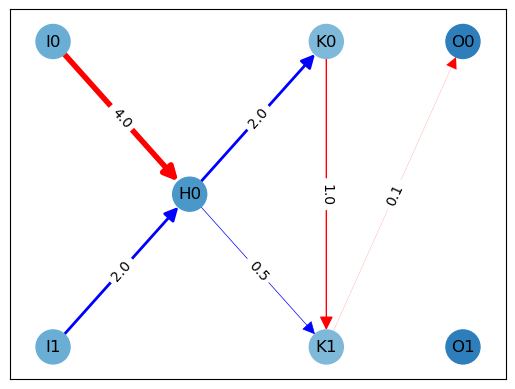

In [5]:
plotter.visualize_network(layers, weights)

### 5. Specify the physics of the nodes
Before running any simulations, we need to specify the input currents and the physics of the hidden layer nodes. Parameters can either be specified directly or coupled from the `physics` module. 

In [6]:
# Specify an exciting current square pulse and an inhibition square pulse
t_blue = [(0.5,0.6)] # a 100 ps pulse at 0.5 ns 
# and inhibition from the other one
t_red = [(0.7,0.78)] # a 80 ps pulse at 0.7 ns 

# Use the square pulse function and specify which node in the input layer gets which pulse
layers[0].set_input_func(channel='blue',func_handle=physics.square_pulse, func_args=t_blue)
layers[0].set_input_func(channel='red', func_handle=physics.square_pulse, func_args=t_red)

# Specify the internal dynamics by supplying the RC constants to the hidden layer (six parameters)
layers[1].set_gammas(physics.example_gammas())
layers[2].set_gammas(physics.example_gammas())

# Specify the transistor mapping Vgate on each node to the source-drain current Isd (function handle)
layers[1].func_Vgate_to_Isd = physics.transistorIV
layers[2].func_Vgate_to_Isd = physics.transistorIV

### 6. Example dynamic simulation

In [7]:
# Start time t, end time T
t = 0.0
T = 10.0 # ns
# To sample result over a fixed time-step, use savetime
savetime = 0.05
# These parameters are used to determine an appropriate time step each update
dtmax = 0.01 # ns 
dVmax = 0.001 # V

nw.reset(layers)
# Create a log over the dynamic data
time_log = logger.Logger(layers,channels) # might need some flags

start = time.time()

while t < T:
    # evolve by calculating derivatives, provides dt
    dt = tm.evolve(t, layers, dVmax, dtmax )

    # update with explicit Euler using dt
    tm.update(dt, t, layers, weights)
    
    t += dt
    # Log the progress
    if t > savetime :
        # Put log update here to have (more or less) fixed sample rate
        pass
    
    time_log.add_tstep(t, layers)

end = time.time()
print('Time used:',end-start)

# This is a large pandas data frame of all system variables
result = time_log.get_timelog()

Time used: 0.20490264892578125


### Visualize results using `plotter` module

Plot results for specific nodes

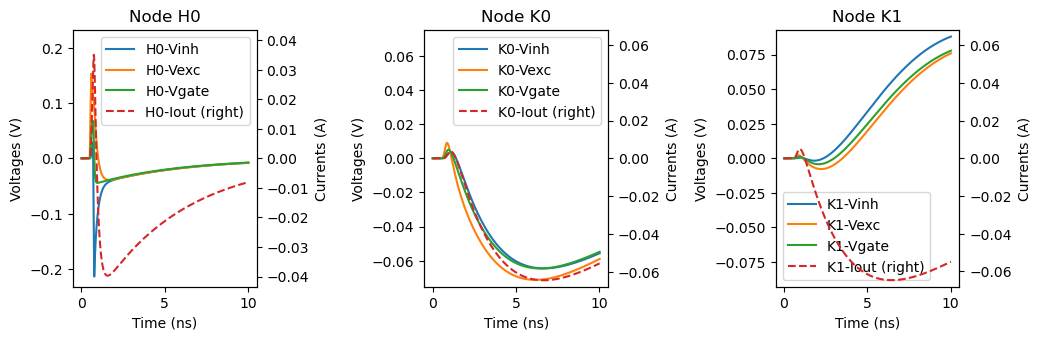

In [8]:
nodes = ['H0','K0','K1']
plotter.plot_nodes(result, nodes)

Plot results by choosing a number of attributes and get a plot comparing all nodes

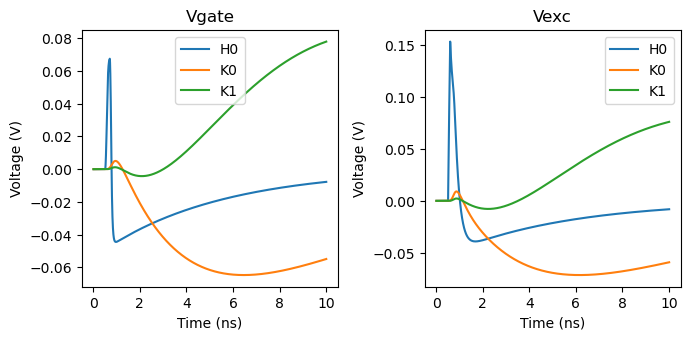

In [9]:
attr_list = ['Vgate','Vexc']
plotter.plot_attributes(result, attr_list)

We can also choose to plot along connected nodes, like from I0 to O0, here with Iout as the variable (Iout is the only variable that exists both in input, output and hidden layers).

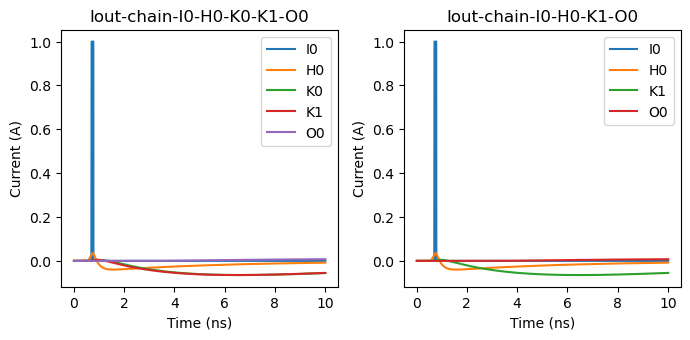

In [11]:
G = plotter.retrieve_G(layers, weights)
plotter.plot_chainlist(result, G, 'I0','O0')

It is also possible to plot an explicit list of variables with the following function

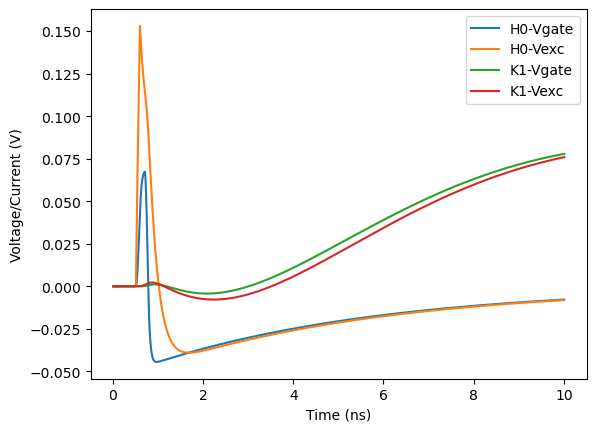

In [12]:
plotter.visualize_dynamic_result(result, ['H0-Vgate','H0-Vexc','K1-Vgate','K1-Vexc'])